In [1]:
import sys
sys.path.append('/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1.1/pytorch/1.13.1-CUDA-11.8.0/lib/python3.9/site-packages')


In [2]:
import torch
print(torch.cuda.is_available())

/user/ritikver/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


In [ ]:
import os
import json
import shutil
from glob import glob
from tqdm import tqdm

splits = ['train', 'val', 'test']
base_dir = "/projects/academic/courses/cse676su25/ritikver/final_proj/checkpoint"
image_input_base = os.path.join(base_dir, "images")
annotation_input_base = os.path.join(base_dir, "annotations")

output_image_base = os.path.join(base_dir, "dataset_full/coco/images")
output_ann_base = os.path.join(base_dir, "dataset_full/coco/ann")
os.makedirs(output_image_base, exist_ok=True)
os.makedirs(output_ann_base, exist_ok=True)

CATEGORIES = {
    "car": 1,
    "traffic light": 2,
    "traffic sign": 3,
    "truck": 4
}
category_list = [{"id": v, "name": k} for k, v in CATEGORIES.items()]

IMAGE_WIDTH = 1280
IMAGE_HEIGHT = 720

global_image_id = 1
global_annotation_id = 1

for split in splits:
    image_input_dir = os.path.join(image_input_base, split)
    annotation_input_dir = os.path.join(annotation_input_base, split)

    image_output_dir = os.path.join(output_image_base, split)
    os.makedirs(image_output_dir, exist_ok=True)

    json_files = sorted(glob(os.path.join(annotation_input_dir, "*.json")))   
    coco_output = {
        "images": [],
        "annotations": [],
        "categories": category_list
    }

    for json_file in tqdm(json_files, desc=f"Processing {split}"):
        file_stem = os.path.splitext(os.path.basename(json_file))[0]
        image_filename = file_stem + ".jpg"
        image_path = os.path.join(image_input_dir, image_filename)

        if not os.path.exists(image_path):
            continue

        # Copy image
        shutil.copy2(image_path, os.path.join(image_output_dir, image_filename))

        # Load annotation JSON
        with open(json_file) as f:
            data = json.load(f)

        # Add image info
        image_id = global_image_id
        coco_output["images"].append({
            "id": image_id,
            "file_name": image_filename,
            "width": IMAGE_WIDTH,
            "height": IMAGE_HEIGHT
        })
        global_image_id += 1

        # Add object annotations
        objects = data.get("frames", [{}])[0].get("objects", [])
        for obj in objects:
            if "box2d" not in obj or obj["category"] not in CATEGORIES:
                continue

            cat_id = CATEGORIES[obj["category"]]
            box = obj["box2d"]
            x1, y1, x2, y2 = map(float, [box["x1"], box["y1"], box["x2"], box["y2"]])
            width = x2 - x1
            height = y2 - y1

            if width <= 0 or height <= 0:
                continue

            coco_output["annotations"].append({
                "id": global_annotation_id,
                "image_id": image_id,
                "category_id": cat_id,
                "bbox": [x1, y1, width, height],
                "area": width * height,
                "iscrowd": 0
            })
            global_annotation_id += 1

    os.makedirs(output_ann_base, exist_ok=True)
    output_json_path = os.path.join(output_ann_base, f"{split}.json")
    with open(output_json_path, "w") as f:
        json.dump(coco_output, f, indent=2)

    print(f"Saved COCO JSON: {output_json_path}")
    print(f"Copied {len(coco_output['images'])} images to: {image_output_dir}")


Processing train: 100%|██████████| 70000/70000 [08:18<00:00, 140.49it/s]


Saved COCO JSON: /projects/academic/courses/cse676su25/ritikver/final_proj/checkpoint/dataset_full/coco/ann/train.json
Copied 70000 images to: /projects/academic/courses/cse676su25/ritikver/final_proj/checkpoint/dataset_full/coco/images/train


Processing val: 100%|██████████| 10000/10000 [01:09<00:00, 142.97it/s]


Saved COCO JSON: /projects/academic/courses/cse676su25/ritikver/final_proj/checkpoint/dataset_full/coco/ann/val.json
Copied 10000 images to: /projects/academic/courses/cse676su25/ritikver/final_proj/checkpoint/dataset_full/coco/images/val


Processing test: 100%|██████████| 20000/20000 [02:19<00:00, 142.93it/s]


Saved COCO JSON: /projects/academic/courses/cse676su25/ritikver/final_proj/checkpoint/dataset_full/coco/ann/test.json
Copied 20000 images to: /projects/academic/courses/cse676su25/ritikver/final_proj/checkpoint/dataset_full/coco/images/test


In [3]:
import os
import torch
import torchvision
import torchvision.transforms as T
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from tqdm import tqdm

#  Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Torch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device name: {torch.cuda.get_device_name(0)}")

# Collate function for DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

# Transform for training data
def get_transform(train=True):
    transforms = [T.ToTensor()]
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


/user/ritikver/.local/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


Using device: cuda
Torch version: 1.13.1
CUDA available: True
Device name: NVIDIA A100-PCIE-40GB


In [4]:
coco_path = "dataset_full/coco"

transform = get_transform(train=True)

train_dataset = CocoDetection(
    root=os.path.join(coco_path, "images", "train"),
    annFile=os.path.join(coco_path, "ann", "train.json"),
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0, 
    collate_fn=collate_fn
)

print(f"Loaded {len(train_dataset)} training samples.")


loading annotations into memory...
Done (t=6.32s)
creating index...
index created!
Loaded 70000 training samples.


In [ ]:
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.models.detection.retinanet import RetinaNetClassificationHead

NUM_CLASSES = 5  # 4 categories + 1 background

# Load pretrained RetinaNet
model = retinanet_resnet50_fpn(pretrained=True)

# Fixed known values for RetinaNet-ResNet50-FPN
in_channels = 256  # Backbone feature map channels
num_anchors = 9     

# Replace classification head
model.head.classification_head = RetinaNetClassificationHead(
    in_channels=in_channels,
    num_anchors=num_anchors,
    num_classes=NUM_CLASSES
)

model.to(device)
model.train()


/user/ritikver/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/user/ritikver/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


In [6]:
import torch
from tqdm import tqdm

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

EPOCHS = 5
W, H = 1280, 720  # Image size

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    skipped_batches = 0

    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images = [img.to(device) for img in images]

        valid_images = []
        formatted_targets = []

        for img, t in zip(images, targets):
            boxes = torch.tensor([ann['bbox'] for ann in t], dtype=torch.float32).reshape(-1, 4)
            boxes[:, 2:] += boxes[:, :2]  # Convert [x, y, w, h] → [x1, y1, x2, y2]
            labels = torch.tensor([ann['category_id'] for ann in t], dtype=torch.long)

            if boxes.numel() == 0 or labels.numel() == 0:
                continue

            boxes[:, [0, 2]] = boxes[:, [0, 2]].clamp(0, W)
            boxes[:, [1, 3]] = boxes[:, [1, 3]].clamp(0, H)

            valid_mask = (boxes[:, 2] > boxes[:, 0] + 1e-3) & (boxes[:, 3] > boxes[:, 1] + 1e-3)
            boxes = boxes[valid_mask]
            labels = labels[valid_mask]

            if boxes.numel() == 0:
                continue
            if not torch.isfinite(boxes).all() or not torch.isfinite(labels).all():
                continue
            if labels.min().item() < 1:
                continue

            valid_images.append(img)
            formatted_targets.append({
                "boxes": boxes.to(device),
                "labels": labels.to(device)
            })

        if len(formatted_targets) == 0:
            skipped_batches += 1
            continue

        if any(not torch.isfinite(img).all() for img in valid_images):
            skipped_batches += 1
            continue

        # Forward pass
        loss_dict = model(valid_images, formatted_targets)
        loss = sum(loss for loss in loss_dict.values())

        if not torch.isfinite(loss):
            print(" Non-finite loss detected, skipping batch")
            skipped_batches += 1
            continue

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        running_loss += loss.item()

    lr_scheduler.step()
    avg_loss = running_loss / max(len(train_loader) - skipped_batches, 1)
    print(f" Epoch {epoch+1} - Avg Loss: {avg_loss:.4f} | Skipped Batches: {skipped_batches}")


Epoch 1/5: 100%|██████████| 17500/17500 [57:01<00:00,  5.11it/s] 


 Epoch 1 - Avg Loss: 1.0080 | Skipped Batches: 0


Epoch 2/5: 100%|██████████| 17500/17500 [56:28<00:00,  5.16it/s] 


 Epoch 2 - Avg Loss: 0.9749 | Skipped Batches: 0


Epoch 3/5: 100%|██████████| 17500/17500 [56:33<00:00,  5.16it/s] 


 Epoch 3 - Avg Loss: 0.9653 | Skipped Batches: 0


Epoch 4/5: 100%|██████████| 17500/17500 [56:41<00:00,  5.14it/s] 


 Epoch 4 - Avg Loss: 0.9177 | Skipped Batches: 0


Epoch 5/5: 100%|██████████| 17500/17500 [56:45<00:00,  5.14it/s] 

 Epoch 5 - Avg Loss: 0.9091 | Skipped Batches: 0


In [7]:
torch.save(model.state_dict(), "retina_full.pth")
print("Model saved to retina_full.pth")


Model saved to retina_full.pth


In [8]:
torch.save(model, "retina_full_model.pth")
print("Entire model saved to retina_full_model.pth")


Entire model saved to retina_full_model.pth


In [16]:
def collate_fn(batch):
    return tuple(zip(*batch))

from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import os


coco_root = "/projects/academic/courses/cse676su25/ritikver/final_proj/checkpoint/dataset/coco"

# Validation dataset
val_dataset = CocoDetection(
    root=os.path.join(coco_root, "images", "val"),
    annFile=os.path.join(coco_root, "annotations", "val.json"),
    transform=get_transform(train=False)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

# Test dataset
test_dataset = CocoDetection(
    root=os.path.join(coco_root, "images", "test"),
    annFile=os.path.join(coco_root, "annotations", "test.json"),
    transform=get_transform(train=False)
)

test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


loading annotations into memory...
Done (t=1.31s)
creating index...
index created!
loading annotations into memory...
Done (t=2.35s)
creating index...
index created!
Validation samples: 10000
Test samples: 20000


In [3]:
import torch
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.models.detection.retinanet import RetinaNetClassificationHead

NUM_CLASSES = 5  
in_channels = 256
num_anchors = 9

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = retinanet_resnet50_fpn(pretrained=True)
model.head.classification_head = RetinaNetClassificationHead(
    in_channels=in_channels,
    num_anchors=num_anchors,
    num_classes=NUM_CLASSES
)

model.load_state_dict(torch.load("retina_full.pth", map_location=device))
model.to(device)
model.eval()

/Users/riverma99/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/riverma99/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


loading annotations into memory...
Done (t=1.43s)
creating index...
index created!

 Image 1


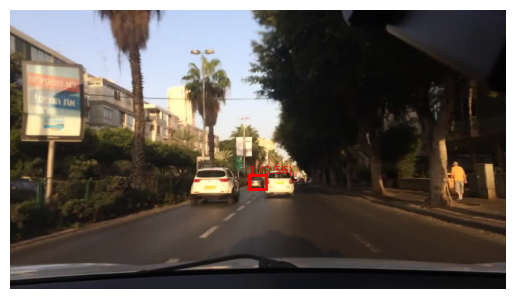


 Image 2


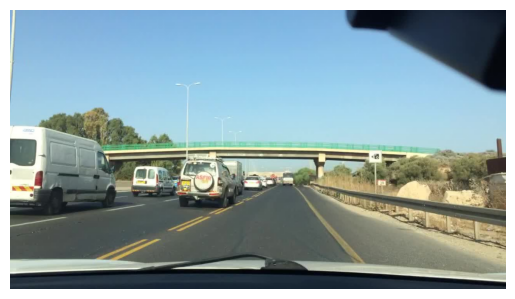


 Image 3


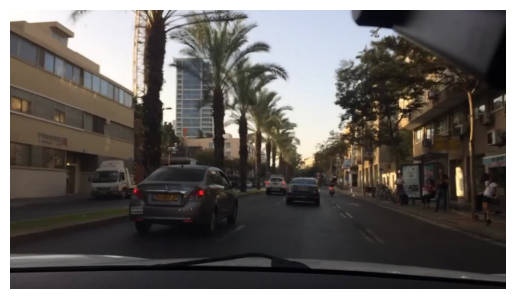


 Image 4


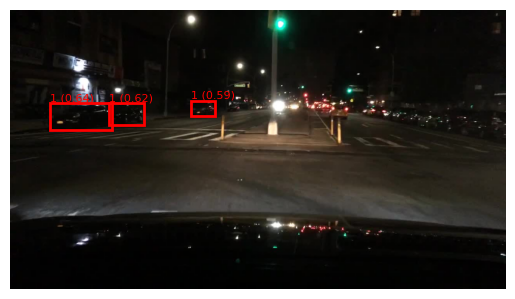


 Image 5


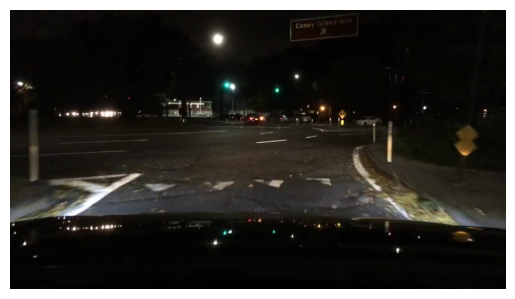

In [4]:
import os
import torch
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches

BATCH_SIZE = 1
CONFIDENCE_THRESHOLD = 0.5
NUM_SAMPLES = 5  

coco_root = "/Users/riverma99/Downloads/project_checkpoint_ritikver_hgowdarm_nsoni/project_checkpoint_ritikver_hgowdarm_nsoni/coco"
image_root = os.path.join(coco_root, "images/test")
annotation_file = os.path.join(coco_root, "ann/test.json")

def get_transform():
    return transforms.Compose([transforms.ToTensor()])

test_dataset = CocoDetection(root=image_root, annFile=annotation_file, transform=get_transform())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

def visualize_prediction(img_tensor, preds, threshold=0.5):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for box, label, score in zip(preds["boxes"], preds["labels"], preds["scores"]):
        if score >= threshold:
            x1, y1, x2, y2 = box.tolist()
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1 - 5, f"{label.item()} ({score:.2f})", color='red', fontsize=8)
    plt.axis('off')
    plt.show()

model.eval()
with torch.no_grad():
    for idx, (images, _) in enumerate(test_loader):
        images = [img.to(device) for img in images]
        outputs = model(images)

        print(f"\n Image {idx + 1}")
        visualize_prediction(images[0], outputs[0], threshold=CONFIDENCE_THRESHOLD)

        if idx + 1 >= NUM_SAMPLES:
            break

In [7]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json
from tqdm import tqdm
import torch

MAX_IMAGES = 1000
result_file = "retina_predictions_full_1k.json"

with open(annotation_file, "r") as f:
    gt_data = json.load(f)

if "info" not in gt_data:
    gt_data["info"] = {
        "description": "Auto-patched COCO annotation",
        "version": "1.0",
        "year": 2025,
        "contributor": "Ritik Verma",
        "date_created": "2025-06-23"
    }
    # Save temporary patched file
    patched_annotation_file = "patched_annotations.json"
    with open(patched_annotation_file, "w") as f:
        json.dump(gt_data, f)
else:
    patched_annotation_file = annotation_file

# Load GT annotations
coco_gt = COCO(patched_annotation_file)

# Generate predictions
results = []
image_ids_used = []

model.eval()
counter = 0

with torch.no_grad():
    for images, targets in tqdm(test_loader, desc="Generating predictions"):
        if counter >= MAX_IMAGES:
            break

        images = [img.to(device) for img in images]
        outputs = model(images)

        for img_tensor, output, target in zip(images, outputs, targets):
            if len(target) == 0:
                continue

            image_id = target[0]["image_id"]
            image_ids_used.append(image_id)

            for box, score, label in zip(output["boxes"], output["scores"], output["labels"]):
                x1, y1, x2, y2 = box.tolist()
                width = x2 - x1
                height = y2 - y1
                results.append({
                    "image_id": image_id,
                    "category_id": label.item(),
                    "bbox": [x1, y1, width, height],
                    "score": score.item()
                })

            counter += 1
            if counter >= MAX_IMAGES:
                break

with open(result_file, "w") as f:
    json.dump(results, f)

# Run COCO evaluation
coco_dt = coco_gt.loadRes(result_file)
coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
coco_eval.params.imgIds = image_ids_used
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=1.11s)
creating index...
index created!


Generating predictions:   5%|▌         | 1000/20000 [21:18<6:44:48,  1.28s/it]


Loading and preparing results...
DONE (t=3.43s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=20.85s).
Accumulating evaluation results...
DONE (t=1.59s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.231
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.465
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.206
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.090
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.378
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.490
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.132
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.359
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.418
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1